In [230]:
"""
STEPS
1. Find the image collection corresponding to LANDSAT7 data
2. Filter the collection to January 2005 outside of the rainy season
3. Load in village location data
4. Create function to load in lat and long data from each village row
5. Function creates EE.Geometry.Point object from each lat and long and sets a buffer of a certain radius
6. Function loads in all bands of data from that image and inputs it into correspond row of new dataframe
7. Function adds village category to each row
8. Train neural network to predict whether there is a village, destroyed village, or no settlmment in the image
"""

'\nSTEPS\n1. Find the image collection corresponding to LANDSAT7 data\n2. Filter the collection to January 2005 outside of the rainy season\n3. Load in village location data\n4. Create function to load in lat and long data from each village row\n5. Function creates EE.Geometry.Point object from each lat and long and sets a buffer of a certain radius\n6. Function loads in all bands of data from that image and inputs it into correspond row of new dataframe\n7. Function adds village category to each row\n8. Train neural network to predict whether there is a village, destroyed village, or no settlmment in the image\n'

In [231]:
import ee
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from IPython.display import Image

In [232]:
#Authenticaing API access
ee.Authenticate()

True

In [233]:
#Initialzing Earth Engine
ee.Initialize(project='sudan-1234')

In [234]:
#loading in the LANDSAT7 image data
LANDSAT7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2")

In [235]:
#loading in village data
village_data = pd.read_csv('../Data/village_data.csv')

In [236]:
village_data.head()

,NAME,LATITUDE,LAT_DD,LONGITUDE,LONG_DD,STATUS,STRUCTURES,YR_CONFIRM,APROX_STR1,APROX_STR2,YR_RANGE1,YR_RANGE2,SEC_TOWN
0,NaN,131857,13.315833,0244942,24.828333,DAMAGED,~25 of ~50,NaN,25.0,50.0,NaN,NaN,NaN
1,DOLA,131905,13.318056,0245404,24.901111,DESTROYED,~200 of ~200,2008/2009,200.0,200.0,2008.0,2009.0,NaN
2,LABABIS,131613,13.270278,0244822,24.806111,DESTROYED,~100 of ~100,NaN,100.0,100.0,NaN,NaN,NaN
3,SURRI,131740,13.294444,0245013,24.836944,DESTROYED,~250 of ~300,2004,250.0,300.0,2004.0,2004.0,NaN
4,NANOREE,131813,13.303611,0245206,24.868333,DESTROYED,~75 of ~100,2003/2004,75.0,100.0,2003.0,2004.0,NaN


In [237]:
#dropping irrelevant columns
village_data = village_data[["LAT_DD", "LONG_DD", "STATUS", "YR_CONFIRM"]]

In [238]:
village_data

,LAT_DD,LONG_DD,STATUS,YR_CONFIRM
0,13.315833,24.828333,DAMAGED,NaN
1,13.318056,24.901111,DESTROYED,2008/2009
2,13.270278,24.806111,DESTROYED,NaN
3,13.294444,24.836944,DESTROYED,2004
4,13.303611,24.868333,DESTROYED,2003/2004
...,...,...,...,...
9178,13.024167,24.462500,NO DAMAGE,NaN
9179,12.993611,24.438056,NO DAMAGE,NaN
9180,13.163056,24.690000,NO DAMAGE,NaN
9181,12.995278,24.205000,NO DAMAGE,NaN


In [239]:
#spliting yr_confirm into a list of multiple years
village_data['YR_CONFIRM'] = village_data['YR_CONFIRM'].str.split('/')

#selecting the last year
village_data['YR_CONFIRM'] = village_data['YR_CONFIRM'].apply(lambda x: x if x is np.nan else x[-1])


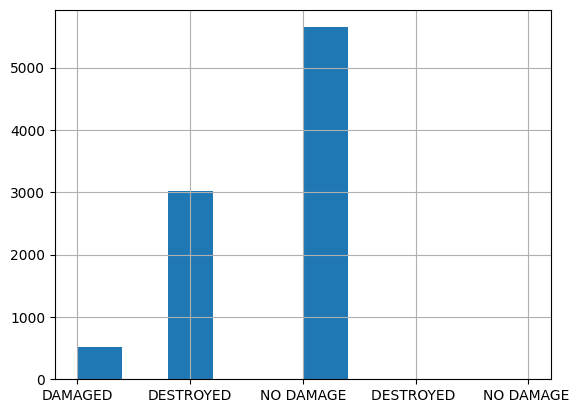

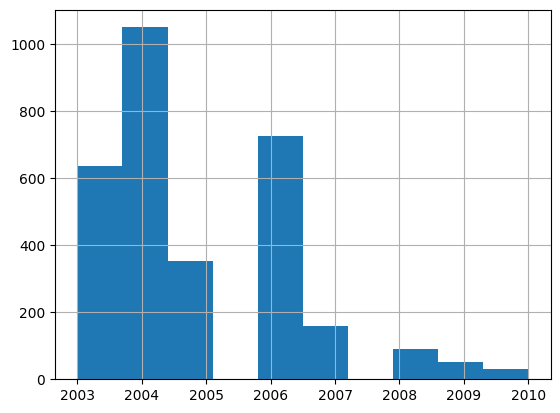

In [240]:
#plotting histograms of categorial data
village_data['STATUS'].hist()
plt.show()

village_data['YR_CONFIRM'] = village_data['YR_CONFIRM'].astype(float)
village_data['YR_CONFIRM'].hist()
plt.show()

In [241]:
#value counts for YR_CONFIRM
village_data['YR_CONFIRM'].value_counts()

YR_CONFIRM
2004.0    1051
2006.0     726
2003.0     636
2005.0     352
2007.0     159
2008.0      89
2009.0      52
2010.0      31
Name: count, dtype: int64

In [242]:
village_data["STATUS"].value_counts()

STATUS
NO DAMAGE     5646
DESTROYED     3019
DAMAGED        516
DESTROYED        1
NO DAMAGE        1
Name: count, dtype: int64

In [243]:
#seperating the village data into one dataframe of of damaged and destroyed villages and one of undamaged villages
damaged_villages = village_data[village_data['STATUS'].isin(["DAMAGED", "DESTROYED"])]
undamaged_villages = village_data[village_data['STATUS'] == "NO DAMAGE"]

In [244]:
#merging status of damaged villages into one category called "DAMAGED"
damaged_villages['STATUS'] = damaged_villages['STATUS'].apply(lambda x: 'DAMAGED')

C:\Users\harsh\AppData\Local\Temp\ipykernel_22048\1666229773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  damaged_villages['STATUS'] = damaged_villages['STATUS'].apply(lambda x: 'DAMAGED')


In [245]:
#limiting damaged villages to be before 2007
damaged_villages = damaged_villages[damaged_villages['YR_CONFIRM'] < 2007]


<Axes: >

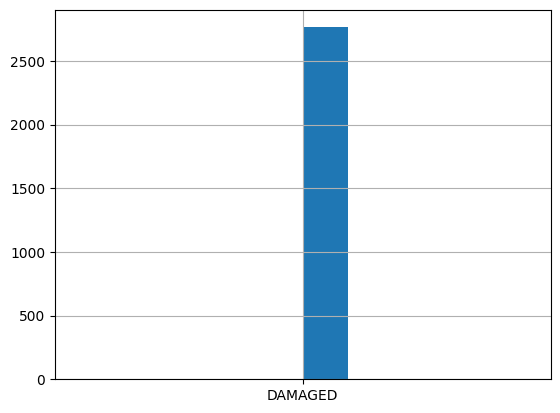

In [246]:
damaged_villages["STATUS"].hist()

In [247]:
#merging damaged and undamaged villages into one dataframe 
village_data = pd.concat([damaged_villages, undamaged_villages])

<Axes: >

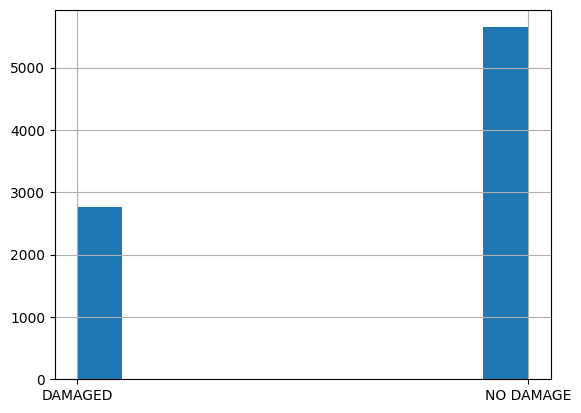

In [248]:
village_data["STATUS"].hist()

In [249]:
#seeing the ratio between the two class sizes
village_data["STATUS"].value_counts()
2764/(5646 + 2764)

#30:70, decent ratio to keep going

0.3286563614744352

In [250]:
village_data

,LAT_DD,LONG_DD,STATUS,YR_CONFIRM
3,13.294444,24.836944,DAMAGED,2004.0
4,13.303611,24.868333,DAMAGED,2004.0
5,13.342222,24.800000,DAMAGED,2004.0
6,13.329167,24.820278,DAMAGED,2004.0
7,13.321111,24.860556,DAMAGED,2004.0
...,...,...,...,...
9178,13.024167,24.462500,NO DAMAGE,NaN
9179,12.993611,24.438056,NO DAMAGE,NaN
9180,13.163056,24.690000,NO DAMAGE,NaN
9181,12.995278,24.205000,NO DAMAGE,NaN


In [251]:
#speicifying first four months of 2007 as the time frame
start_date = '2007-01-01'
end_date = '2007-04-30'

LANDSAT7 = LANDSAT7.select('SR_B1','SR_B2','SR_B3','SR_B4','SR_B5', 'SR_B7').filterDate(start_date, end_date)

In [252]:
#reindex village data from 0 to the end
village_data = village_data.reset_index()

In [253]:
#creates a feature collection of all the village data from LANDSAT7 data

#code is blocked out because it takes too long to run, the output code is saved in Data/village_LANDSAT.csv

#DO NOT DELETE



features = [None] * len(village_data)
for i in range(len(village_data)):
    features[i] = ee.Feature(ee.Geometry.Point(village_data['LONG_DD'][i], village_data['LAT_DD'][i]))

fc = ee.FeatureCollection(features)

village_LANDSAT = pd.DataFrame(columns = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7'])

print(len(features))

def add_image_data(feature):
    point = feature.geometry()
    point = point.buffer(100)
    image = LANDSAT7.filterBounds(point).sort('CLOUD_COVER').first()
    B1 = image.select('SR_B1').reduceRegion(ee.Reducer.mean(), point, 30).get('SR_B1')
    B2 = image.select('SR_B2').reduceRegion(ee.Reducer.mean(), point, 30).get('SR_B2') 
    B3 = image.select('SR_B3').reduceRegion(ee.Reducer.mean(), point, 30).get('SR_B3')
    B4 = image.select('SR_B4').reduceRegion(ee.Reducer.mean(), point, 30).get('SR_B4')
    B5 = image.select('SR_B5').reduceRegion(ee.Reducer.mean(), point, 30).get('SR_B5')
    B7 = image.select('SR_B7').reduceRegion(ee.Reducer.mean(), point, 30).get('SR_B7')
    return feature.set({'B1': B1, 'B2': B2, 'B3': B3, 'B4': B4, 'B5': B5, 'B7': B7})


for i in range(0,9):
    batch = ee.FeatureCollection(features[i*1000:(i+1)*1000])
    selected = features[i*1000:(i+1)*1000]
    batch = batch.map(add_image_data)
    cols = batch.getInfo()['features']
    df = pd.DataFrame([col['properties'] for col in cols])
    village_LANDSAT = pd.concat([village_LANDSAT, df], ignore_index=True)


village_LANDSAT

village_LANDSAT.to_csv('../Data/LANDSAT_BANDS.csv', index=False)



8410


C:\Users\harsh\AppData\Local\Temp\ipykernel_22048\643701098.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  village_LANDSAT = pd.concat([village_LANDSAT, df], ignore_index=True)


In [254]:
village_LANDSAT = pd.read_csv('../Data/LANDSAT_BANDS.csv')

In [255]:
#loading in lat and long from village data and adding to village_LANDSAT

lat_long = village_data[['LAT_DD', 'LONG_DD']] 

village_LANDSAT = pd.concat([lat_long, village_LANDSAT], axis=1)


In [256]:
#adding NBR and NDVI

NBR = (village_LANDSAT['B4'] - village_LANDSAT['B7'])/(village_LANDSAT['B4'] + village_LANDSAT['B7'])
NDVI = (village_LANDSAT['B4'] - village_LANDSAT['B3'])/(village_LANDSAT['B4'] + village_LANDSAT['B3'])

village_LANDSAT['NBR'] = NBR
village_LANDSAT['NDVI'] = NDVI


In [257]:
#Adding visible bands, all bands, 4+5, and 4+5+7

village_LANDSAT['B4+B5'] = village_LANDSAT['B4'] + village_LANDSAT['B5']  
village_LANDSAT['B4+B5+B7'] = village_LANDSAT['B4+B5'] + village_LANDSAT['B7']
village_LANDSAT['B1+B2+B3+B4+B5+B7'] = village_LANDSAT['B1'] + village_LANDSAT['B2'] + village_LANDSAT['B3'] + village_LANDSAT['B4'] + village_LANDSAT['B5'] + village_LANDSAT['B7']
village_LANDSAT['B1+B2+B3'] = village_LANDSAT['B1'] + village_LANDSAT['B2'] + village_LANDSAT['B3']



In [258]:
#adding status
village_LANDSAT['STATUS'] = village_data['STATUS']

village_LANDSAT

,LAT_DD,LONG_DD,B1,B2,B3,B4,B5,B7,NBR,NDVI,B4+B5,B4+B5+B7,B1+B2+B3+B4+B5+B7,B1+B2+B3,STATUS
0,13.294444,24.836944,10841.162406,13148.307236,16005.625428,19001.184889,22311.267861,19530.643575,-0.013741,0.085571,41312.452751,60843.096325,100838.191395,39995.095070,DAMAGED
1,13.303611,24.868333,10442.426843,12475.081831,15035.104428,17676.975234,22225.059347,20854.035494,-0.082455,0.080761,39902.034581,60756.070075,98708.683177,37952.613102,DAMAGED
2,13.342222,24.800000,10767.284752,13008.971331,15870.784009,19303.726099,21712.331925,17579.258138,0.046755,0.097597,41016.058024,58595.316162,98242.356254,39647.040091,DAMAGED
3,13.329167,24.820278,10471.542945,12485.620509,15037.908635,18256.125356,19407.163112,16361.050074,0.054744,0.096660,37663.288468,54024.338542,92019.410631,37995.072089,DAMAGED
4,13.321111,24.860556,10846.557699,13014.151124,15713.607693,18371.613971,21392.022029,20012.540121,-0.042750,0.077981,39763.636000,59776.176121,99350.492638,39574.316516,DAMAGED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8405,13.024167,24.462500,9942.443083,11146.044346,12641.739356,14668.761845,15458.044852,13965.270878,0.024568,0.074221,30126.806696,44092.077574,77822.304359,33730.226785,NO DAMAGE
8406,12.993611,24.438056,9939.814058,11307.782493,13217.178515,15826.847215,16838.210610,15221.111671,0.019510,0.089852,32665.057825,47886.169496,82350.944562,34464.775066,NO DAMAGE
8407,13.163056,24.690000,11187.728527,13680.510779,16485.530854,19668.345500,23864.617543,20736.744268,-0.026442,0.088035,43532.963043,64269.707312,105623.477472,41353.770161,NO DAMAGE
8408,12.995278,24.205000,10366.493671,11711.912419,13255.104801,16887.708747,17153.066598,15016.518075,0.058650,0.120513,34040.775345,49057.293420,84390.804311,35333.510891,NO DAMAGE


In [259]:
village_LANDSAT.dropna(inplace=True)


In [260]:
village_LANDSAT.to_csv('../Data/village_LANDSAT.csv', index=False)